# Part 1.2: Feature Extraction

 **Feature Extraction** using:
1. **PCA (Principal Component Analysis)** 
2. **LDA (Linear Discriminant Analysis)** 



In [1]:
""" import os
# depend on where you save the data
os.chdir('./data')
os.getcwd() """

" import os\n# depend on where you save the data\nos.chdir('./data')\nos.getcwd() "

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

## Load data

In [3]:
wb_df = pd.read_csv('./data/worldbank_gender_2021.csv')
wb_df.tail()

,Country Name,Year,Agricultural irrigated land (% of total agricultural land),Agricultural land (% of land area),"Agriculture, forestry, and fishing, value added (% of GDP)",Arable land (% of land area),Cereal yield (kg per hectare),Crop production index (2014-2016 = 100),Fertilizer consumption (kilograms per hectare of arable land),Food production index (2014-2016 = 100),...,Merchandise imports (current US$),Merchandise trade (% of GDP),"Contributing family workers, female (% of female employment) (modeled ILO estimate)","Contributing family workers, male (% of male employment) (modeled ILO estimate)",Firms with female participation in ownership (% of firms),Firms with female top manager (% of firms),"Proportion of time spent on unpaid domestic and care work, female (% of 24 hour day)","Proportion of time spent on unpaid domestic and care work, male (% of 24 hour day)","Women making their own informed decisions regarding sexual relations, contraceptive use and reproductive health care (% of women age 15-49)",Gender Ratio Class
211,Virgin Islands (U.S.),2021,NaN,9.43,NaN,2.57,NaN,NaN,NaN,NaN,...,NaN,NaN,0.34,0.21,NaN,NaN,NaN,NaN,NaN,5.0
212,West Bank and Gaza,2021,NaN,64.93,6.32,6.95,2251.9,117.31,371.97,117.39,...,NaN,NaN,8.55,3.44,NaN,NaN,NaN,NaN,NaN,5.0
213,"Yemen, Rep.",2021,NaN,44.42,NaN,2.19,1524.8,124.71,10.63,120.77,...,5.054000e+09,29.68,37.64,9.04,NaN,NaN,NaN,NaN,NaN,1.0
214,Zambia,2021,NaN,32.07,3.00,5.11,2525.0,136.31,63.90,127.49,...,6.435000e+09,74.84,4.87,2.36,NaN,NaN,NaN,NaN,NaN,5.0
215,Zimbabwe,2021,NaN,41.88,8.85,10.34,1545.3,129.97,25.98,120.52,...,7.577000e+09,47.98,0.12,0.11,NaN,NaN,NaN,NaN,NaN,5.0


In [4]:
regions_df = pd.read_excel('./data/countries_regions.xlsx')
regions_df.head()

,CountryName,Region,ThirdWorld
0,Afghanistan,South Asia,Yes
1,Albania,Eastern Europe,No
2,Algeria,Africa,No
3,American Samoa,Australia and Oceanea,No
4,Andorra,Western Europe,No


In [5]:
# Rename country names to match between datasets
name_map = {
    'United States': 'United States of America',
    'Viet Nam': 'Vietnam',
}

wb_df['Country Name'] = wb_df['Country Name'].replace(name_map)


In [6]:
# Merge WorldBank and Region datasets
combined_df = wb_df.merge(
    regions_df,
    left_on='Country Name',
    right_on='CountryName',
    how='inner'
)
combined_df = combined_df.drop(columns=['CountryName'])

print(f"Combined dataset shape: {combined_df.shape}")
combined_df.head()

Combined dataset shape: (216, 198)


,Country Name,Year,Agricultural irrigated land (% of total agricultural land),Agricultural land (% of land area),"Agriculture, forestry, and fishing, value added (% of GDP)",Arable land (% of land area),Cereal yield (kg per hectare),Crop production index (2014-2016 = 100),Fertilizer consumption (kilograms per hectare of arable land),Food production index (2014-2016 = 100),...,"Contributing family workers, female (% of female employment) (modeled ILO estimate)","Contributing family workers, male (% of male employment) (modeled ILO estimate)",Firms with female participation in ownership (% of firms),Firms with female top manager (% of firms),"Proportion of time spent on unpaid domestic and care work, female (% of 24 hour day)","Proportion of time spent on unpaid domestic and care work, male (% of 24 hour day)","Women making their own informed decisions regarding sexual relations, contraceptive use and reproductive health care (% of women age 15-49)",Gender Ratio Class,Region,ThirdWorld
0,Afghanistan,2021,6.51,58.74,33.60,12.00,2099.0,125.67,5.20,114.32,...,60.87,12.79,NaN,NaN,NaN,NaN,NaN,1.0,South Asia,Yes
1,Albania,2021,16.54,41.47,18.36,21.89,5144.7,114.68,NaN,104.92,...,27.58,15.96,NaN,NaN,NaN,NaN,NaN,1.0,Eastern Europe,No
2,Algeria,2021,NaN,17.35,11.23,3.16,1433.7,108.76,20.68,104.83,...,2.10,1.61,NaN,NaN,NaN,NaN,NaN,1.0,Africa,No
3,American Samoa,2021,NaN,14.50,NaN,4.85,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Australia and Oceanea,No
4,Andorra,2021,NaN,39.91,0.53,1.59,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Western Europe,No


In [7]:
th = len(combined_df)*0.5
combined_df.dropna(thresh=th, axis=1,inplace=True)

In [8]:
# Define column types
target_col = 'Gender Ratio Class'

exclude_cols = ['Country Name', target_col]
num_cols = [col for col in combined_df.select_dtypes(include=[np.number]).columns if col not in exclude_cols]

cat_cols = [col for col in combined_df.select_dtypes(include=['object']).columns if col not in exclude_cols]

print(f"Target: {target_col}")
print(f"Numeric columns: {len(num_cols)}")
print(f"Categorical columns: {len(cat_cols)}")

Target: Gender Ratio Class
Numeric columns: 102
Categorical columns: 2


In [9]:
combined_df = combined_df.dropna(subset=[target_col])

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt

## Data Preparation

In [11]:
X_raw = combined_df[num_cols + cat_cols].copy()
y_raw = combined_df[target_col].copy()


print(f"Dataset Shape: {X_raw.shape}")
print(f"Classes: {y_raw.unique()}")
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=42, stratify=y_raw
)

print(f"Train size: {X_train.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

# Preprocessing
X_train_proc = X_train.copy()
X_test_proc = X_test.copy()

# Handle categorical columns with Label Encoding
for col in cat_cols:
    if col in X_train_proc.columns:
        mode_val = X_train_proc[col].mode()[0]
        X_train_proc[col] = X_train_proc[col].fillna(mode_val)
        X_test_proc[col] = X_test_proc[col].fillna(mode_val)
        
        le = LabelEncoder()
        le.fit(X_train_proc[col].astype(str))
        known_labels = set(le.classes_)
        train_mode_str = X_train_proc[col].astype(str).mode()[0]
        X_test_proc[col] = X_test_proc[col].astype(str).apply(
            lambda x: x if x in known_labels else train_mode_str
        )
        X_train_proc[col] = le.transform(X_train_proc[col].astype(str))
        X_test_proc[col] = le.transform(X_test_proc[col])

# Handle numeric columns with median imputation + outlier clipping
num_cols_actual = [c for c in num_cols if c in X_train_proc.columns]
for col in num_cols_actual:
    med = X_train_proc[col].median()
    X_train_proc[col] = X_train_proc[col].fillna(med)
    X_test_proc[col] = X_test_proc[col].fillna(med)
    
    lower = X_train_proc[col].quantile(0.05)
    upper = X_train_proc[col].quantile(0.95)
    X_train_proc[col] = X_train_proc[col].clip(lower, upper)
    X_test_proc[col] = X_test_proc[col].clip(lower, upper)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_proc)
X_test_scaled = scaler.transform(X_test_proc)

print(f"Preprocessed features: {X_train_scaled.shape[1]}")

Dataset Shape: (186, 104)
Classes: [1. 5. 4. 3. 2.]
Train size: 148
Test size: 38
Preprocessed features: 104


## 1. Feature Extraction using PCA

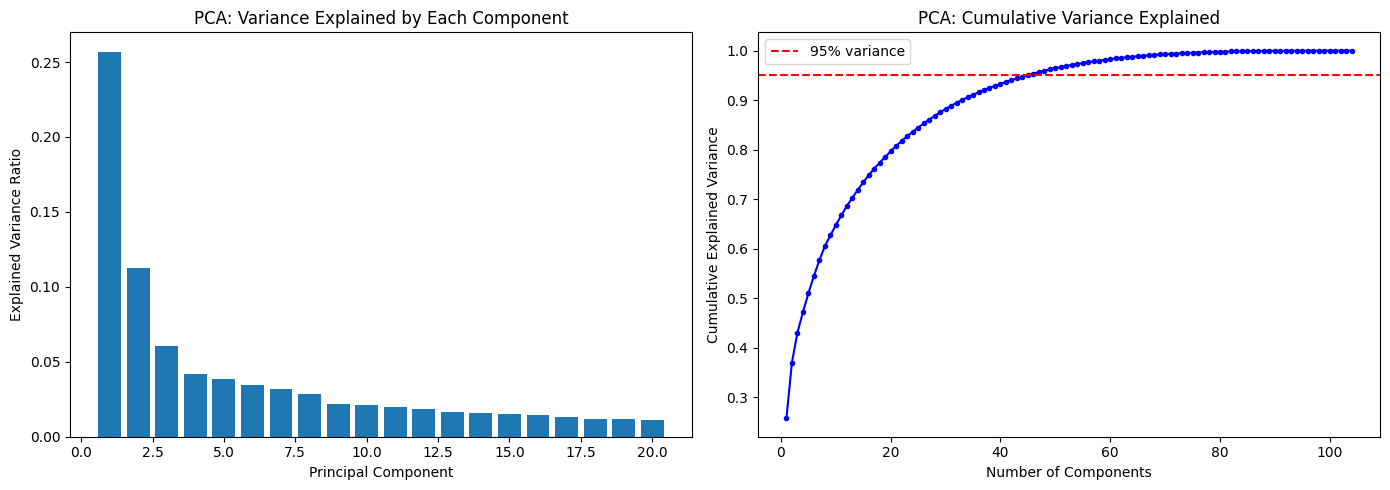

Components for 95% variance: 45


In [12]:
pca_full = PCA()
pca_full.fit(X_train_scaled)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(1, min(21, len(pca_full.explained_variance_ratio_)+1)), 
            pca_full.explained_variance_ratio_[:20])
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('PCA: Variance Explained by Each Component')

axes[1].plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'b-o', markersize=3)
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% variance')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('PCA: Cumulative Variance Explained')
axes[1].legend()

plt.tight_layout()
plt.show()

n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Components for 95% variance: {n_components_95}")

In [13]:
n_pca_components = n_components_95

pca = PCA(n_components=n_pca_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"PCA transformed shape: {X_train_pca.shape}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.4f}")

PCA transformed shape: (148, 45)
Total variance explained: 0.9507


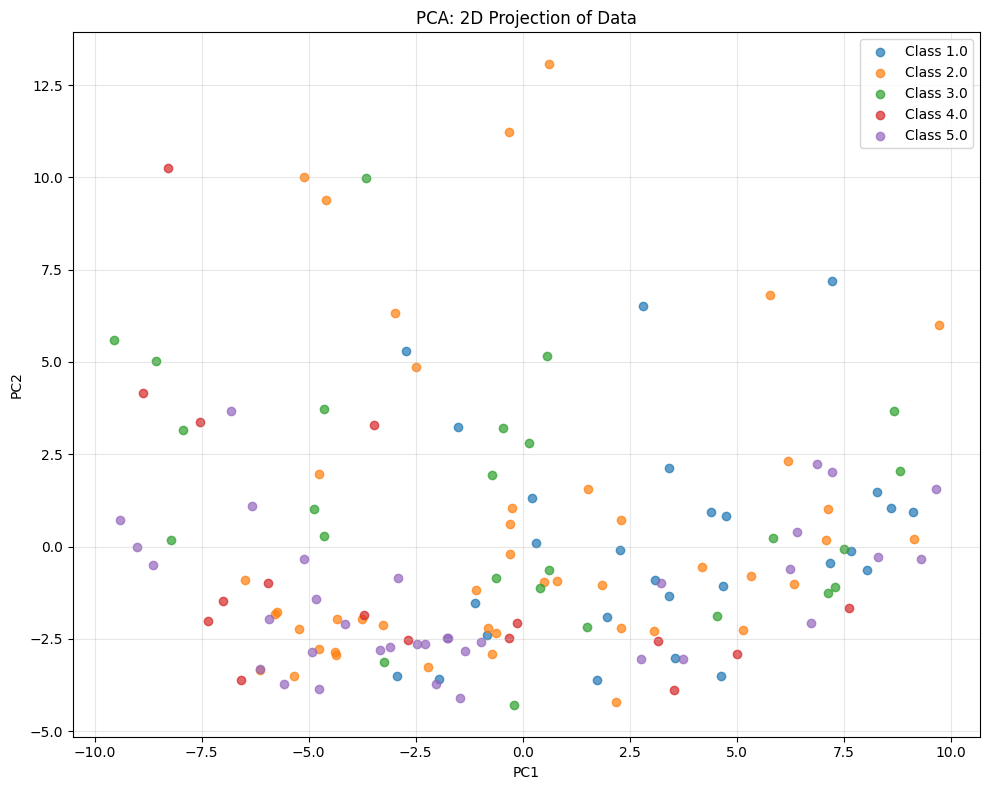

In [14]:
# Visualize PCA components
plt.figure(figsize=(10, 8))

for label in np.unique(y_train):
    plt.scatter(
        X_train_pca[y_train == label, 0],
        X_train_pca[y_train == label, 1],
        label=f'Class {label}',
        alpha=0.7
    )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: 2D Projection of Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
# PCA: Top 5 Contributors for First 4 PCs


pca_loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=X_train_proc.columns
)

n_pcs = 4
for i in range(n_pcs):
    pc_name = f'PC{i+1}'
    top5 = pca_loadings[pc_name].abs().nlargest(5)
    print(f"\n{pc_name}:")
    for feat in top5.index:
        val = pca_loadings.loc[feat, pc_name]
        print(f"  {feat}: {val:.4f}")


PC1:
  Population ages 0-14 (% of total population): 0.1804
  Birth rate, crude (per 1,000 people): 0.1800
  Life expectancy at birth, female (years): -0.1765
  Life expectancy at birth, total (years): -0.1744
  Fertility rate, total (births per woman): 0.1717

PC2:
  Population, total: 0.2761
  Labor force, total: 0.2738
  Urban population: 0.2723
  Rural population: 0.2401
  GNI, PPP (current international $): 0.2399

PC3:
  Labor force, female (% of total labor force): 0.2909
  Death rate, crude (per 1,000 people): 0.2307
  Diabetes prevalence (% of population ages 20 to 79): -0.2218
  Industry (including construction), value added (% of GDP): -0.2090
  Population, female (% of total population): 0.2060

PC4:
  Arable land (% of land area): 0.2655
  Permanent cropland (% of land area): 0.2509
  Forest area (sq. km): -0.2076
  Industry (including construction), value added (% of GDP): -0.1991
  Land area (sq. km): -0.1903


## 2. Feature Extraction using LDA


In [16]:
# Determine number of components
n_classes = len(y_train.unique())
n_features = X_train_scaled.shape[1]
max_lda_components = min(n_classes - 1, n_features)

print(f"Number of classes: {n_classes}")
print(f"Number of features: {n_features}")
print(f"Max LDA components: {max_lda_components}")

# Apply LDA
lda = LinearDiscriminantAnalysis(n_components=max_lda_components)
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

print(f"\nLDA transformed shape: {X_train_lda.shape}")
print(f"Explained variance ratio: {lda.explained_variance_ratio_}")

Number of classes: 5
Number of features: 104
Max LDA components: 4

LDA transformed shape: (148, 4)
Explained variance ratio: [0.47737791 0.25769533 0.15675782 0.10816894]


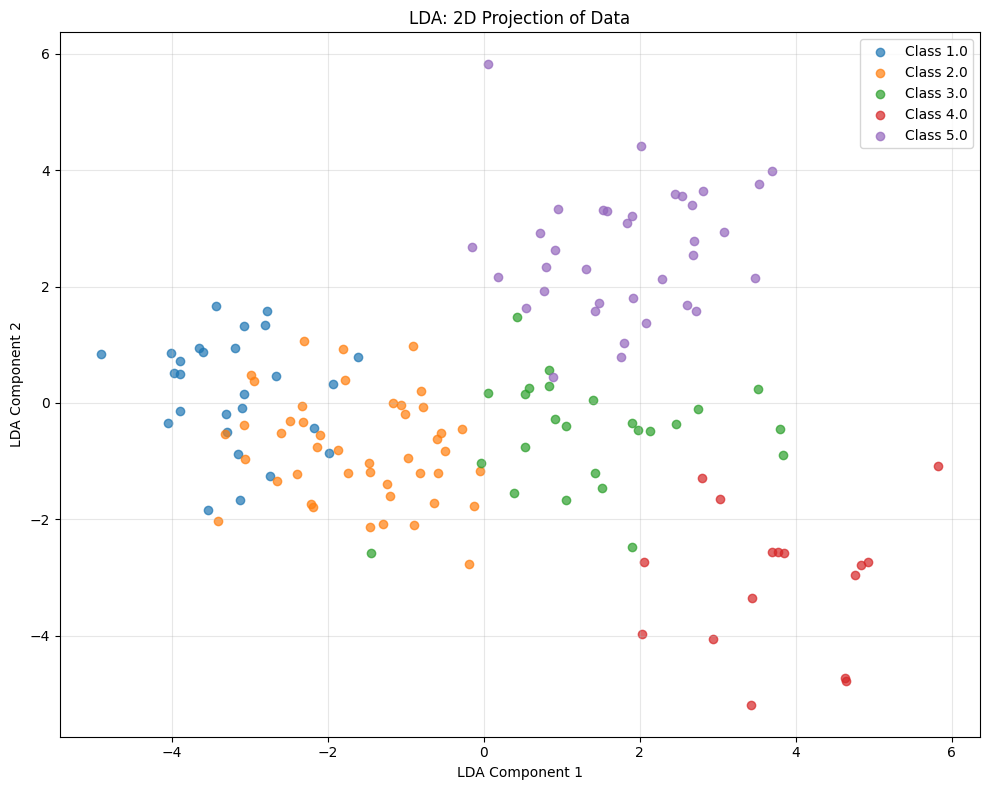

In [17]:

plt.figure(figsize=(10, 8))

for label in np.unique(y_train):
    plt.scatter(
        X_train_lda[y_train == label, 0],
        X_train_lda[y_train == label, 1],
        label=f'Class {label}',
        alpha=0.7
    )

plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.title('LDA: 2D Projection of Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [18]:
# LDA: Top 5 Contributors for First 4 LDs
lda_scalings = pd.DataFrame(
    lda.scalings_[:, :max_lda_components],
    columns=[f'LD{i+1}' for i in range(max_lda_components)],
    index=X_train_proc.columns
)

n_lds = 4
for i in range(n_lds):
    ld_name = f'LD{i+1}'
    top5 = lda_scalings[ld_name].abs().nlargest(5)
    print(f"\n{ld_name}:")
    for feat in top5.index:
        val = lda_scalings.loc[feat, ld_name]
        print(f"  {feat}: {val:.4f}")


LD1:
  Life expectancy at birth, total (years): -15.7905
  Life expectancy at birth, male (years): 8.1376
  Surface area (sq. km): -6.7842
  Land area (sq. km): 5.8712
  Life expectancy at birth, female (years): 4.3615

LD2:
  Life expectancy at birth, total (years): 26.5585
  Life expectancy at birth, female (years): -15.4109
  Surface area (sq. km): -13.4249
  Land area (sq. km): 12.9558
  Life expectancy at birth, male (years): -11.2402

LD3:
  Life expectancy at birth, total (years): 50.5875
  Surface area (sq. km): 32.1980
  Land area (sq. km): -31.1959
  Life expectancy at birth, female (years): -28.4509
  Life expectancy at birth, male (years): -20.4602

LD4:
  Age dependency ratio (% of working-age population): 8.4274
  Land area (sq. km): 7.8674
  Surface area (sq. km): -7.3821
  Population ages 15-64 (% of total population): 7.0345
  Life expectancy at birth, total (years): 5.9186
